## Project Title : Analysing key cities to set up a vegetable/fruit distribution centre that will cater mainly to restaurants

#### Downloading necessary libraries

In [3]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

import json 
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.5.0 --yes
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    ------------------------------------------------------------
                       

#### Setting display options

In [24]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

#### Scrapping data for Toronto from wikipedia and creating the required dataframe

In [4]:
#scrapping data from url

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
dfs = pd.read_html(url, header=0) # set header with row #0

In [5]:
#creating the required dataframe

df = dfs[0]
indexNames = df[ df['Borough'] == 'Not assigned' ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# cleaning data with required index

index = range(1,df.shape[0]+1,1)
df["index"] = index
df.set_index('index', inplace = True)



In [6]:
##number of rows in the dataframe

print("The number of rows in the dataframe are ",df.shape[0])
print("")
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]))

The number of rows in the dataframe are  103

The dataframe has 10 boroughs and 103 neighborhoods.


#### Loading the location coordinates and combining it with the wikipedia data

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
Toronto_neighbourhood_data = df.join(df_loc.set_index('Postal Code'), on='Postal Code')

### Toronto neighbourhood location data has been scrapped and cleaned

#### Scrapping data for NewYork from json file and creating the required dataframe

In [10]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [11]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

In [12]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
New_york_neighborhood_data = pd.DataFrame(columns=column_names)


In [13]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 

    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    New_york_neighborhood_data = New_york_neighborhood_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

    

In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(New_york_neighborhood_data['Borough'].unique()),
        New_york_neighborhood_data.shape[0]))


The dataframe has 5 boroughs and 306 neighborhoods.


### NewYork neighbourhood location data has been scrapped and cleaned

#### Scrapping data for Paris from www.aggdata.com and creating the required dataframe


In [15]:

body = client_95108c8f82f34b54982decd79935f282.get_object(Bucket='capstoneproject-donotdelete-pr-nh7h5jhihjbeey',Key='Paris_loc_data.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_0 = pd.read_excel(body)
df_data_0.head()


,Postal Code,Place Name,Latitude,Longitude
0,75001,Paris 01 Louvre,48.8592,2.3417
1,75002,Paris 02 Bourse,48.8655,2.3426
2,75003,Paris 03 Temple,48.8637,2.3615
3,75004,Paris 04 HÙtel-de-Ville,48.8601,2.3507
4,75005,Paris 05 PanthÈon,48.8448,2.3471


In [16]:
Paris_neighborhood_data = df_data_0.loc[0:19]

In [17]:
print('The dataframe has {} administration zones.'.format(
        Paris_neighborhood_data.shape[0]))

The dataframe has 20 administration zones.


#### Assumption : Data with respect to locations in the neighbourhood of Paris is not available. However data is available for 20 administration zones in Paris. We will select these zones and increase our search radius in comparison to New York and Toronto. Another point to consider is that the area of Paris is 105 sqkm. While that of Toronto and New York are 630 sqkm and 783 sqkm respectively.

### Paris neighbourhood location data has been scrapped and cleaned

### Summarising the data

In [18]:
print('The Toronto dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Toronto_neighbourhood_data['Borough'].unique()),
        df.shape[0]))

print('The New york dataframe has {} boroughs and {} neighborhoods.'.format(
        len(New_york_neighborhood_data['Borough'].unique()),
        New_york_neighborhood_data.shape[0]))


print('The Paris dataframe has {} administration zones.'.format(
        Paris_neighborhood_data.shape[0]))

The Toronto dataframe has 10 boroughs and 103 neighborhoods.
The New york dataframe has 5 boroughs and 306 neighborhoods.
The Paris dataframe has 20 administration zones.


### Preparing Data for one hot encoding

In [19]:
# The code was removed by Watson Studio for sharing.

#### Toronto - Venue request from foresquare ; Radius taken per venue will be 300

In [20]:
radius = 300
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhoods in zip(Toronto_neighbourhood_data['Latitude'], Toronto_neighbourhood_data['Longitude'], Toronto_neighbourhood_data['Postal Code'], Toronto_neighbourhood_data['Borough'], Toronto_neighbourhood_data['Neighborhood']):
    
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
  
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhoods,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [196]:
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Postal_Code', 'Borough', 'Neighborhoods', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1151, 9)


,Postal_Code,Borough,Neighborhoods,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M3A,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M4A,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
2,M4A,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
3,M4A,North York,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,North York,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant


#### Analysing top 10 categories in Toronto (Macro Analysis)

In [197]:
tor_cat = venues_df['VenueCategory'].value_counts()
top10_tor_cat = tor_cat[:10]



#### Focusing on targeted venue categories (bars/cafe/restaurants/hotels/malls/shops)

In [258]:
Req_colm = ['Caf','Shop','Rest','Place','Sand','Bar','Hotel','Bod','Pub','Grocery','Breakfast','Burger','Steak','Diner','Mall','Food','Market','Joint','Market','Farmer','Motel','Lounge','Bistro','Brewery']


In [259]:
unique = venues_df['VenueCategory'].unique()

coln_reqd = []


for i in Req_colm:
    i = i.lower()
    
    for j in unique:
        j_lower = j.lower()
        if j_lower.find(i) != -1:
            coln_reqd.append(j)

    
    


In [260]:
len(coln_reqd)

127

In [261]:
x = np.array(coln_reqd) 
y = np.unique(x)
len(y)


115

In [221]:
print("There are ",len(y) ," unique categories that will be considered")

There are  115  unique categories that will be considered


In [204]:
list_fin = y.tolist()


### One hot encoding toronto with 115 venue categories

In [224]:
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
toronto_onehot['Neighborhoods'] = venues_df['Neighborhoods']

cols = toronto_onehot.columns.tolist()


# move the column name to the beggining
cols.insert(0, cols.pop(cols.index('Neighborhoods')))


#then use .reindex() function to reorder
toronto_onehot = toronto_onehot.reindex(columns= cols)

In [225]:
columns = ['Neighborhoods'] +list_fin

toronto_onehot = toronto_onehot[columns]

In [226]:
toronto_onehot.shape

(1151, 116)

In [227]:
neighborhood_group = toronto_onehot.groupby('Neighborhoods').mean().reset_index()

In [232]:
print('There are {} uniques categories and {} neighborhoods in Toronto that will be clustered and analysed.'.format(neighborhood_group.shape[1]-1,neighborhood_group['Neighborhoods'].unique().shape[0]))

There are 115 uniques categories and 79 neighborhoods in Toronto that will be clustered and analysed.


In [231]:
neighborhood_group.head()

,Neighborhoods,Airport Food Court,Airport Lounge,American Restaurant,Arepa Restaurant,Asian Restaurant,Auto Workshop,BBQ Joint,Bar,Beer Bar,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gaming Cafe,Gastropub,Gay Bar,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Hakka Restaurant,Health Food Store,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Lounge,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motel,New American Restaurant,Organic Grocery,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Smoothie Shop,Soup Place,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.000000,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.0,0.0,0.071429,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.071429,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0

### One hot encoding for Toronto has been completed

#### NewYork - Venue request from foresquare ; Radius taken per venue will be 150

In [233]:
# The code was removed by Watson Studio for sharing.

In [238]:
radius = 150
LIMIT = 100

venues = []

for lat, long, borough, neighborhoods in zip(New_york_neighborhood_data['Latitude'], New_york_neighborhood_data['Longitude'], New_york_neighborhood_data['Borough'], New_york_neighborhood_data['Neighborhood']):
    
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append(( 
            borough,
            neighborhoods,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

#### Analysing top 10 categories in New York (Macro Analysis)

In [239]:
venues_df_ny = pd.DataFrame(venues)

# define the column names
venues_df_ny.columns = [ 'Borough', 'Neighborhoods', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df_ny.shape)
venues_df_ny.head()

(1467, 8)


,Borough,Neighborhoods,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
2,Bronx,Co-op City,40.874294,-73.829939,truman track n field,40.874963,-73.830847,Baseball Field
3,Bronx,Eastchester,40.887556,-73.827806,Cozy Cottage Restaurant,40.886332,-73.827616,Diner
4,Bronx,Fieldston,40.895437,-73.905643,Fieldston Road Circle,40.894489,-73.905621,Plaza


In [244]:
tor_cat_ny = venues_df_ny['VenueCategory'].value_counts()
top10_tor_cat_ny = tor_cat_ny[:10]


In [264]:
Req_colm = ['Caf','Shop','Rest','Place','Sand','Bar','Hotel','Bod','Pub','Grocery','Breakfast','Burger','Steak','Diner','Mall','Food','Market','Joint','Market','Farmer','Motel','Lounge','Bistro','Brewery','BBQ','Store','Noodle']


In [265]:
unique = venues_df_ny['VenueCategory'].unique()

coln_reqd = []


for i in Req_colm:
    i = i.lower()
    
    for j in unique:
        j_lower = j.lower()
        if j_lower.find(i) != -1:
            coln_reqd.append(j)



In [266]:
len(coln_reqd)

169

In [267]:
x = np.array(coln_reqd) 
y = np.unique(x)
len(y)

151

In [268]:
print("There are ",len(y) ," unique categories that will be considered")

There are  151  unique categories that will be considered


In [269]:
list_fin = y.tolist()

### One hot encoding New York with 151 venue categories

In [281]:
new_york_onehot = pd.get_dummies(venues_df_ny[['VenueCategory']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
new_york_onehot['Neighborhoods'] = venues_df_ny['Neighborhoods'] 

cols = new_york_onehot.columns.tolist()


cols.insert(0, cols.pop(cols.index('Neighborhoods')))


new_york_onehot = new_york_onehot.reindex(columns= cols)

In [282]:
columns = ['Neighborhoods'] +list_fin

new_york_onehot = new_york_onehot[columns]

In [286]:
neighborhood_group_newyork = new_york_onehot.groupby('Neighborhoods').mean().reset_index()

In [288]:
print('There are {} uniques categories and {} neighborhoods in New York that will be clustered and analysed.'.format(neighborhood_group_newyork.shape[1]-1,new_york_onehot['Neighborhoods'].unique().shape[0]))

There are 151 uniques categories and 222 neighborhoods in New York that will be clustered and analysed.


### One hot encoding for NY has been completed

#### Paris - one hot encoding ; Radius taken per venue will be 500

In [289]:
radius = 500
LIMIT = 100

venues = []

for lat, long, admin_zone, postal_code in zip(Paris_neighborhood_data['Latitude'], Paris_neighborhood_data['Longitude'], Paris_neighborhood_data['Place Name'], Paris_neighborhood_data['Postal Code']):
    
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append(( 
            admin_zone,
            postal_code,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

#### Analysing top 10 categories in New York (Macro Analysis)

In [290]:
venues_df_paris = pd.DataFrame(venues)

# define the column names
venues_df_paris.columns = [ 'Administration Zone', 'Postal Code', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df_paris.shape)
venues_df_paris.head()

(1254, 8)


,Administration Zone,Postal Code,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Paris 01 Louvre,75001,48.8592,2.3417,Place du Louvre,48.859841,2.340822,Plaza
1,Paris 01 Louvre,75001,48.8592,2.3417,Église Saint-Germain-l'Auxerrois (Église Saint-Germain l'Auxerrois),48.859520,2.341306,Church
2,Paris 01 Louvre,75001,48.8592,2.3417,Coffee Crêpes,48.858841,2.340802,Coffee Shop
3,Paris 01 Louvre,75001,48.8592,2.3417,Le Fumoir,48.860424,2.340868,Cocktail Bar
4,Paris 01 Louvre,75001,48.8592,2.3417,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza


In [294]:
tor_cat_paris = venues_df_paris['VenueCategory'].value_counts()
top10_tor_cat_paris = tor_cat_paris[:10]



In [322]:
Req_colm = ['Creperie','Caf','Shop','Rest','Place','Sand','Bar','Hotel','Bod','Pub','Grocery','Breakfast','Burger','Steak','Diner','Mall','Food','Market','Joint','Market','Farmer','Motel','Lounge','Bistro','Brewery','BBQ','Store','Noodle']

unique = venues_df_paris['VenueCategory'].unique()

coln_reqd = []


for i in Req_colm:
    i = i.lower()
    
    for j in unique:
        j_lower = j.lower()
        if j_lower.find(i) != -1:
            coln_reqd.append(j)
            


In [323]:
len(coln_reqd)

150

In [324]:
x = np.array(coln_reqd) 
y = np.unique(x)
len(y)

134

In [325]:
print("There are ",len(y) ," unique categories that will be considered")

There are  134  unique categories that will be considered


In [326]:
list_fin = y.tolist()

#### One hot encoding Paris with 134 venue categories

In [327]:
paris_onehot = pd.get_dummies(venues_df_paris[['VenueCategory']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
paris_onehot['Administration Zone'] = venues_df_paris['Administration Zone'] 


cols = paris_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Administration Zone')))
paris_onehot = paris_onehot.reindex(columns= cols)


In [328]:
columns = ['Administration Zone'] +list_fin

In [331]:
paris_onehot = paris_onehot[columns]

In [332]:
neighborhood_group_paris_onehot = paris_onehot.groupby('Administration Zone').mean().reset_index()

In [334]:
print('There are {} uniques categories and {} adminstration zones in Paris that will be clustered and analysed.'.format(neighborhood_group_paris_onehot.shape[1]-1,paris_onehot['Administration Zone'].unique().shape[0]))

There are 134 uniques categories and 20 adminstration zones in Paris that will be clustered and analysed.


### One hot encoding for Paris has been completed

In [339]:
a = neighborhood_group.shape[1]-1
b = neighborhood_group['Neighborhoods'].unique().shape[0]
r1 = 300
x = venues_df.shape[0]

c = neighborhood_group_newyork.shape[1]-1
d = new_york_onehot['Neighborhoods'].unique().shape[0]
r2 = 150
y = venues_df_ny.shape[0]

e = neighborhood_group_paris_onehot.shape[1]-1
f = paris_onehot['Administration Zone'].unique().shape[0]
r3 = 500
z = venues_df_paris.shape[0]



data = [[a,b,r1,x],[c,d,r2,y],[e,f,r3,z]]


In [341]:
df1 = pd.DataFrame(data, index =['Toronto', 'New York','Paris'], columns =['Unique Categories', 'Neighborhoods/Zone','Radius for explore','Venues explored']) 

df1

,Unique Categories,Neighborhoods/Zone,Radius for explore,Venues explored
Toronto,115,79,300,1151
New York,151,222,150,1467
Paris,134,20,500,1254


#### As can be seen in the summary, the radius for exploring venues has been selected in a manner to bring the number of unique categories and venues explored  as close as possible for each city

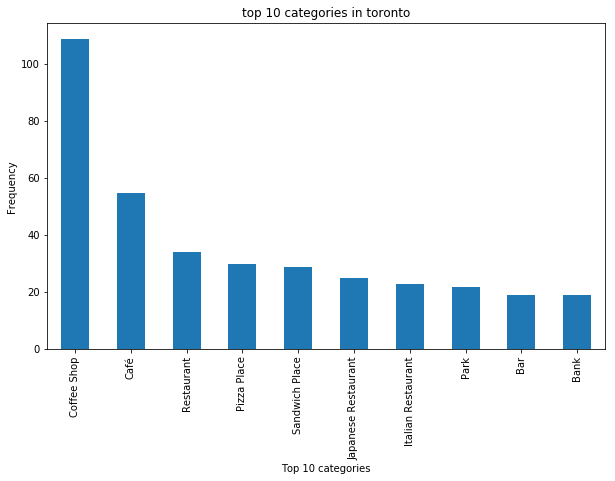

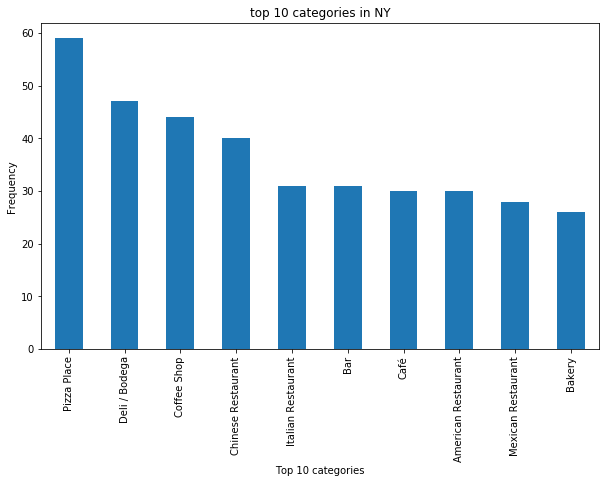

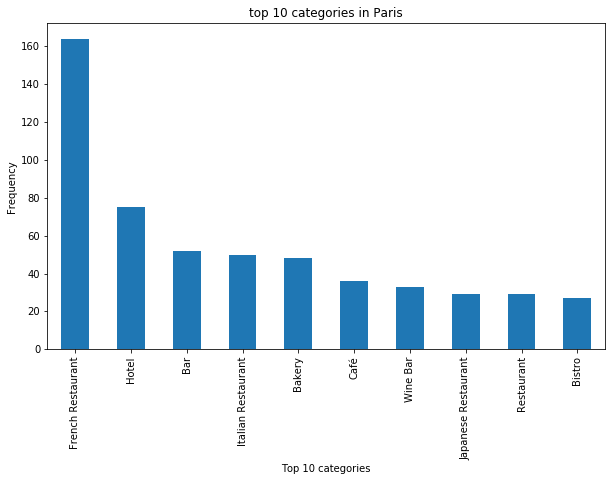

In [342]:

top10_tor_cat.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel("Top 10 categories")
plt.ylabel("Frequency")
plt.title('top 10 categories in toronto')

plt.show()

top10_tor_cat_ny.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel("Top 10 categories")
plt.ylabel("Frequency")
plt.title('top 10 categories in NY')

plt.show()

top10_tor_cat_paris.plot(kind='bar', figsize=(10, 6), rot=90) 

plt.xlabel("Top 10 categories")
plt.ylabel("Frequency")
plt.title('top 10 categories in Paris')

plt.show()

### Based on the bar graphs plotted above. I have made the following observations based on my preliminary analysis;

   <ol>
<li>The top 10 categories in Toronto have few restaurant categories as compared to New York/Paris. Toronto is more dominated by Cafes and Coffee Shops which are not heavy consumers of vegetables and fruits.</li>
<li>Hence we narrow our focus on New York and Paris and carry out cluster analysis using K-means for both cities.</li>
<li>However it should noted that Paris seems more lucrative than New York to establish a vegetable and fruit distribution warehouse.
     <ul>
<li>Greater number of restaurants in Paris than New York</li>
<li>New York has higher proportion of cafes/coffee houses which are not heavy consumers of vegetables and fruits.</li>

</ul></li>
</ol

### Applying machine learning techniques to form clusters for Paris/NewYork Thereafter we can focus on the important cluster

In [343]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))



### Applying unsupervised K means machine learning algorithim 

#### New York Clustering

In [369]:
# create a new dataframe
neighborhoods_venues__newyork_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues__newyork_sorted['Neighborhoods'] = neighborhood_group_newyork['Neighborhoods']


for ind in np.arange(neighborhood_group_newyork.shape[0]):
    neighborhoods_venues__newyork_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_group_newyork.iloc[ind, :], num_top_venues)

In [371]:
clustering_newyork = neighborhood_group_newyork.drop('Neighborhoods',1)

In [376]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_newyork)

# check cluster labels generated for each row in the dataframe
a = kmeans.labels_

unique_elements, counts_elements = np.unique(a, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  0   1   2   3   4   5   6]
 [ 14 177  10  17   1   1   2]]


In [ ]:
#add clustering labels
neighborhoods_venues__newyork_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


#merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
final_newyork = neighborhoods_venues__newyork_sorted.join(New_york_neighborhood_data.set_index('Neighborhood'), on='Neighborhoods')



### New York Map

In [ ]:


address = 'New York City, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [379]:
# add markers to the map


markers_colors = []
for lat, lon, poi, cluster in zip(final_newyork['Latitude'], final_newyork['Longitude'], final_newyork['Neighborhoods'], final_newyork['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
   
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [389]:
list_col=[]

for i in range(2, final_newyork.shape[1]):
    list_col.append(i)

### NY Cluster analysis


In [408]:
ny_cluster_one = final_newyork.loc[final_newyork['Cluster Labels'] == 1, final_newyork.columns[[1] + list_col]]

In [426]:
ny_cluster_one

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
2,Arlington,Women's Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Staten Island,40.635325,-74.165104
3,Astoria,Liquor Store,Fast Food Restaurant,Women's Store,Falafel Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Farmers Market,Electronics Store,Queens,40.768509,-73.915654
5,Bath Beach,Liquor Store,Pizza Place,Middle Eastern Restaurant,Ice Cream Shop,Bagel Shop,Falafel Restaurant,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Brooklyn,40.599519,-73.998752
6,Battery Park City,Food Court,American Restaurant,Food Truck,Mexican Restaurant,BBQ Joint,Sandwich Place,Bar,Burrito Place,Gastropub,Women's Store,Manhattan,40.711932,-74.016869
7,Bay Ridge,Italian Restaurant,Grocery Store,Cosmetics Shop,Coffee Shop,Chinese Restaurant,Caucasian Restaurant,Lounge,Spanish Restaurant,Bookstore,Sushi Restaurant,Brooklyn,40.625801,-74.030621
8,Bay Terrace,Video Store,Clothing Store,Women's Store,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Queens,40.782843,-73.776802
8,Bay Terrace,Video Store,Clothing Store,Women's Store,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Staten Island,40.553988,-74.139166
9,Bedford Stuyvesant,Women's Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Brooklyn,40.687232,-73.941785
10,Belle Harbor,Women's Store,Food,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Queens,40.576156,-73.854018
11,Bellerose,Asian Restaurant,Women's Store,Electronics Store,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Queens,40.728573,-73.720128


In [413]:
series_one = ny_cluster_one['1st Most Common Venue'].value_counts()
series_two = ny_cluster_one['2nd Most Common Venue'].value_counts()
series_three = ny_cluster_one['3rd Most Common Venue'].value_counts()

In [422]:
df_series1 = pd.DataFrame(series_one)
df_series2 = pd.DataFrame(series_two)
df_series3 = pd.DataFrame(series_three)

In [423]:
df_series1 = df_series1[:5]
df_series2 = df_series2[:5]
df_series3 = df_series3[:5]

In [425]:
print("CLUSTER ONE")
display(df_series1)
print("CLUSTER ONE")
display(df_series2)
print("CLUSTER ONE")
display(df_series3)

CLUSTER ONE


,1st Most Common Venue
Women's Store,43
Deli / Bodega,9
Ice Cream Shop,7
Bar,6
Liquor Store,6


CLUSTER ONE


,2nd Most Common Venue
Food,43
Women's Store,27
Coffee Shop,7
Grocery Store,6
Deli / Bodega,6


CLUSTER ONE


,3rd Most Common Venue
Flea Market,46
Falafel Restaurant,15
Electronics Store,12
Women's Store,12
Pizza Place,7


In [409]:
ny_cluster_three = final_newyork.loc[final_newyork['Cluster Labels'] == 3, final_newyork.columns[[1] + list_col]]

In [421]:
final_newyork.loc[final_newyork['Cluster Labels'] == 4, final_newyork.columns[[1] + list(range(2, final_newyork.shape[1]))]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Latitude,Longitude
1,Bath Beach,Pizza Place,Ice Cream Shop,Halal Restaurant,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Brooklyn,40.599519,-73.998752
2,Battery Park City,Food Court,Park,Mexican Restaurant,Sandwich Place,Gastropub,Boat or Ferry,Bar,BBQ Joint,Food Truck,Cooking School,Manhattan,40.711932,-74.016869
3,Bay Ridge,Chinese Restaurant,Italian Restaurant,Spa,Sushi Restaurant,Lounge,Pool Hall,Coffee Shop,Bookstore,Greek Restaurant,Hookah Bar,Brooklyn,40.625801,-74.030621
6,Boerum Hill,French Restaurant,Sushi Restaurant,American Restaurant,Japanese Restaurant,Bakery,Thrift / Vintage Store,Farmers Market,Eye Doctor,Falafel Restaurant,Fast Food Restaurant,Brooklyn,40.685683,-73.983748
8,Brighton Beach,Gourmet Shop,Sushi Restaurant,Bookstore,Varenyky restaurant,Eastern European Restaurant,Grocery Store,Coffee Shop,Restaurant,Diner,Dessert Shop,Brooklyn,40.576825,-73.965094
9,Brooklyn Heights,Yoga Studio,Ice Cream Shop,Mexican Restaurant,Bakery,Women's Store,Gift Shop,Massage Studio,Flower Shop,Optical Shop,Deli / Bodega,Brooklyn,40.695864,-73.993782
11,Bushwick,Thrift / Vintage Store,Bar,Pizza Place,Deli / Bodega,Coffee Shop,Mediterranean Restaurant,Halal Restaurant,Gym Pool,Fish Market,Fish & Chips Shop,Brooklyn,40.698116,-73.925258
12,Carroll Gardens,Coffee Shop,Cocktail Bar,Italian Restaurant,Gift Shop,Farmers Market,Shoe Store,Café,Restaurant,Breakfast Spot,Chinese Restaurant,Brooklyn,40.680540,-73.994654
13,Castle Hill,Pharmacy,Diner,Supermarket,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Bronx,40.819014,-73.848027
14,Central Harlem,Cosmetics Shop,Gym / Fitness Center,Deli / Bodega,Cocktail Bar,Café,Cycle Studio,Breakfast Spot,Fried Chicken Joint,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant,Manhattan,40.815976,-73.943211


In [427]:
series_one = ny_cluster_three['1st Most Common Venue'].value_counts()
series_two = ny_cluster_three['2nd Most Common Venue'].value_counts()
series_three = ny_cluster_three['3rd Most Common Venue'].value_counts()

In [428]:
df_series1 = pd.DataFrame(series_one)
df_series2 = pd.DataFrame(series_two)
df_series3 = pd.DataFrame(series_three)

In [429]:
df_series1 = df_series1[:5]
df_series2 = df_series2[:5]
df_series3 = df_series3[:5]

In [431]:
print("CLUSTER THREE")
display(df_series1)
print("CLUSTER THREE")
display(df_series2)
print("CLUSTER THREE")
display(df_series3)

CLUSTER THREE


,1st Most Common Venue
Pizza Place,8
Deli / Bodega,3
Bar,2
Donut Shop,2
Food Truck,1


CLUSTER THREE


,2nd Most Common Venue
Pizza Place,7
Women's Store,6
Asian Restaurant,1
Fried Chicken Joint,1
Diner,1


CLUSTER THREE


,3rd Most Common Venue
Electronics Store,4
Women's Store,3
Falafel Restaurant,2
Donut Shop,2
Convenience Store,1


### Conclusion : After choosing the top two clusters and thereafter tabulating the top three common venues for each cluster, it is noted that food outlets are not prominent amongst the top three venues in each neighborhood cluster. 

### Paris Clustering

In [432]:
# create a new dataframe
neighborhoods_venues__paris_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues__paris_sorted['Neighborhoods'] = neighborhood_group_paris_onehot['Administration Zone']

for ind in np.arange(neighborhood_group_paris_onehot.shape[0]):
    neighborhoods_venues__paris_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_group_paris_onehot.iloc[ind, :], num_top_venues)

In [433]:
clustering_paris = neighborhood_group_paris_onehot.drop('Administration Zone',1)

In [434]:
kclusters = 2


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_paris)

# check cluster labels generated for each row in the dataframe
a = kmeans.labels_

unique_elements, counts_elements = np.unique(a, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[ 0  1]
 [ 9 11]]


In [435]:
#add clustering labels
neighborhoods_venues__paris_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


#merge paris_grouped with toronto_data to add latitude/longitude for each neighborhood
final_paris = neighborhoods_venues__paris_sorted.join(Paris_neighborhood_data.set_index('Place Name'), on='Neighborhoods')




### Paris Map

In [437]:
address = 'Paris'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [479]:
# add markers to the map


markers_colors = []
for lat, lon, poi, cluster in zip(final_paris['Latitude'], final_paris['Longitude'], final_paris['Neighborhoods'], final_paris['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
   
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Paris Cluster Analysis

In [440]:
list_col=[]

for i in range(2, final_paris.shape[1]):
    list_col.append(i)

In [464]:
paris_cluster0 = final_paris.loc[final_paris['Cluster Labels'] == 0, final_paris.columns[[1] + list_col]]

In [480]:
paris_cluster0

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Latitude,Longitude
1,Paris 02 Bourse,French Restaurant,Wine Bar,Pizza Place,Italian Restaurant,Cocktail Bar,Bistro,Cheese Shop,Pastry Shop,Restaurant,Hotel,75002,48.8655,2.3426
5,Paris 06 Luxembourg,French Restaurant,Hotel,Chocolate Shop,Wine Bar,Pastry Shop,Restaurant,Clothing Store,Cocktail Bar,Miscellaneous Shop,Coffee Shop,75006,48.8493,2.3300
6,Paris 07 Palais-Bourbon,French Restaurant,Hotel,Café,Italian Restaurant,Bistro,Coffee Shop,Chocolate Shop,Restaurant,Seafood Restaurant,Japanese Restaurant,75007,48.8565,2.3210
13,Paris 14 Observatoire,French Restaurant,Bar,Italian Restaurant,Hotel,Vietnamese Restaurant,Bistro,Ice Cream Shop,Fish Market,Southwestern French Restaurant,Restaurant,75014,48.8331,2.3264
14,Paris 15 Vaugirard,French Restaurant,Hotel,Bar,Coffee Shop,Italian Restaurant,Supermarket,Thai Restaurant,Japanese Restaurant,Korean Restaurant,Lebanese Restaurant,75015,48.8412,2.3003
15,Paris 16 Passy,French Restaurant,Café,Grocery Store,Chinese Restaurant,Supermarket,Sandwich Place,Restaurant,Pizza Place,Asian Restaurant,Italian Restaurant,75016,48.8637,2.2769
16,Paris 17 Batignolles-Monceau,French Restaurant,Bar,Wine Bar,Hotel,Italian Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Bookstore,Creperie,75017,48.8835,2.3219
17,Paris 18 Buttes-Montmartre,French Restaurant,Bar,Café,Pizza Place,Italian Restaurant,Restaurant,Gastropub,Deli / Bodega,Wine Bar,Coffee Shop,75018,48.8925,2.3444
18,Paris 19 Buttes-Chaumont,French Restaurant,Italian Restaurant,Bar,Restaurant,Supermarket,Seafood Restaurant,Lebanese Restaurant,Moroccan Restaurant,Hotel,Vietnamese Restaurant,75019,48.8817,2.3822


In [465]:
series_one = paris_cluster0['1st Most Common Venue'].value_counts()
series_two = paris_cluster0['2nd Most Common Venue'].value_counts()
series_three = paris_cluster0['3rd Most Common Venue'].value_counts()

In [466]:
df_series1 = pd.DataFrame(series_one)
df_series2 = pd.DataFrame(series_two)
df_series3 = pd.DataFrame(series_three)

In [467]:
df_series1 = df_series1[:5]
df_series2 = df_series2[:5]
df_series3 = df_series3[:5]

In [468]:
print("CLUSTER ZERO")
display(df_series1)
print("CLUSTER ZERO")
display(df_series2)
print("CLUSTER ZERO")
display(df_series3)

CLUSTER ZERO


,1st Most Common Venue
French Restaurant,9


CLUSTER ZERO


,2nd Most Common Venue
Hotel,3
Bar,3
Italian Restaurant,1
Café,1
Wine Bar,1


CLUSTER ZERO


,3rd Most Common Venue
Bar,2
Café,2
Chocolate Shop,1
Grocery Store,1
Pizza Place,1


In [456]:
paris_cluster1 = final_paris.loc[final_paris['Cluster Labels'] == 1, final_paris.columns[[1] + list_col]]

In [458]:
series_one = paris_cluster1['1st Most Common Venue'].value_counts()
series_two = paris_cluster1['2nd Most Common Venue'].value_counts()
series_three = paris_cluster1['3rd Most Common Venue'].value_counts()

In [459]:
df_series1 = pd.DataFrame(series_one)
df_series2 = pd.DataFrame(series_two)
df_series3 = pd.DataFrame(series_three)

In [460]:
df_series1 = df_series1[:5]
df_series2 = df_series2[:5]
df_series3 = df_series3[:5]

In [462]:
print("CLUSTER ONE")
display(df_series1)
print("CLUSTER ONE")
display(df_series2)
print("CLUSTER ONE")
display(df_series3)

CLUSTER ONE


,1st Most Common Venue
French Restaurant,6
Hotel,4
Japanese Restaurant,1


CLUSTER ONE


,2nd Most Common Venue
Hotel,3
Bar,2
French Restaurant,2
Breakfast Spot,1
Ice Cream Shop,1


CLUSTER ONE


,3rd Most Common Venue
Japanese Restaurant,2
Bar,2
Café,2
Seafood Restaurant,1
Bistro,1


### Conclusion : After choosing the top two clusters and tabulating the top three common venues for each cluster, we can confidently conclude that Paris is more attractive than New york in terms of setting up a vegetable/fruit distribution centre. Food outlets are very prominent in the top two neighborhood clusters of Paris.

In [488]:
print('Completed :)')

Completed :)
